<center>
    <h1>Python Proficiency</h1>
    <h4>Jeff Lam</h4>
    <h4><s>April 17<sup>th</sup></s> May 5<sup>th</sup>, 2025</h4>
</center>

## $\small{\emptyset}$ `pip` Installs

In [3]:
! pip install sqlalchemy

In [1]:
! pip install pycairo

   ---------------------------------------- 0.0/841.5 kB ? eta -:--:--
   ---------------------------------------- 10.2/841.5 kB ? eta -:--:--
    -------------------------------------- 20.5/841.5 kB 217.9 kB/s eta 0:00:04
   - ------------------------------------- 41.0/841.5 kB 326.8 kB/s eta 0:00:03
   ----- -------------------------------- 112.6/841.5 kB 656.4 kB/s eta 0:00:02
   -------------------- ------------------- 440.3/841.5 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------  839.7/841.5 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 841.5/841.5 kB 3.3 MB/s eta 0:00:00


In [1]:
! pip install igraph

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
    --------------------------------------- 0.0/2.0 MB 435.7 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.0 MB 656.4 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/2.0 MB 1.4 MB/s eta 0:00:02
   ------- -------------------------------- 0.4/2.0 MB 1.9 MB/s eta 0:00:01
   --------------- ------------------------ 0.8/2.0 MB 3.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.6/2.0 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------  2.0/2.0 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 5.5 MB/s eta 0:00:00


## 0 Imports

In [35]:
import sqlalchemy
import pandas as pd
import numpy as np
import igraph as ig
import re
from itertools import combinations

## 1 Get Data Using `sqlalchemy`

In [9]:
engine = sqlalchemy.create_engine("sqlite:///chinook/chinook.db")

artists_df = pd.read_sql("SELECT * FROM artists", engine)
tracks_df = pd.read_sql("SELECT * FROM tracks", engine)
albums_df = pd.read_sql("SELECT * FROM albums", engine) # helper table

## 2 Comprehensive Table via `pandas.merge()`

In [11]:
df = tracks_df.merge(albums_df, on="AlbumId").merge(artists_df, on="ArtistId").rename(columns={"Name_x": "Track", "Name_y": "Artists"}) # just generically calling the merged dataframe "df"

df

,TrackId,Track,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,Title,ArtistId,Artists
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99,For Those About To Rock We Salute You,1,AC/DC
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99,Balls to the Wall,2,Accept
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99,Restless and Wild,2,Accept
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99,Restless and Wild,2,Accept
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99,Restless and Wild,2,Accept
...,...,...,...,...,...,...,...,...,...,...,...,...
3498,3499,Pini Di Roma (Pinien Von Rom) \ I Pini Della V...,343,2,24,None,286741,4718950,0.99,Respighi:Pines of Rome,226,Eugene Ormandy
3499,3500,"String Quartet No. 12 in C Minor, D. 703 ""Quar...",344,2,24,Franz Schubert,139200,2283131,0.99,Schubert: The Late String Quartets & String Qu...,272,Emerson String Quartet
3500,3501,"L'orfeo, Act 3, Sinfonia (Orchestra)",345,2,24,Claudio Monteverdi,66639,1189062,0.99,Monteverdi: L'Orfeo,273,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon..."
3501,3502,"Quintet for Horn, Violin, 2 Violas, and Cello ...",346,2,24,Wolfgang Amadeus Mozart,221331,3665114,0.99,Mozart: Chamber Music,274,Nash Ensemble


## 3 Data Cleaning

So upon reading the instructions again, I realize I missed this quite important piece of information:
<blockquote>
    1. Get a list of all the artists in the dataset. This requires you to deal with the many formats that the artists are listed in (<mark>some are separated by /, others by &, others with Feat</mark>).
</blockquote>

I have no idea how I missed this the first time, but regardless this essentially help answer one of the grand issues I had from the previous attempt: what are the delimiters to help separate the collaborating artists from each other? Looks like they are `/`, `&`, `Feat`.

### 3.1 Reassigning some values

Still though, there are some value that needs adjusting before we can split via the given delimiters:
1. `AC/DC` can be renamed as `ACDC` to allow `/` delimiter separation (and you could change it back after doing `igraph` but I was too lazy)

2. `Page & Plant` should likewise be changed to `Page and Plant` to allow `&` delimiter separation.
3. Originally, I identified a perculiar entry, `C. Monteverdi, Nigel Rogers - Chiaroscuro; London Baroque; London Cornett & Sackbu`, which seems to rely on a `;` delimiter. I had no idea before how to handle this before, but after extensive research into the names that appeared there (check __Additional References__$-$ yes I separated this just to show this point) I was able to determine which were unique artists, and subsequently changed the `;` delimiter to simply `,` and `&` delimiters.

These edge cases were identified after simply running the following code snippet (I've purposely left it as a Markdown code):
```python
with pd.option_context("display.max_rows", None):
    print(df.Artists.value_counts())
```

In [16]:
df.loc[df.Artists == "AC/DC", "Artists"] = "ACDC"
df.loc[df.Artists == "Page & Plant", "Artists"] = "Page and Plant"
df.loc[df.Artists == "C. Monteverdi, Nigel Rogers - Chiaroscuro; London Baroque; London Cornett & Sackbu", "Artists"] = "C. Monteverdi, Nigel Rogers, Chiaroscuro (Ensemble), London Baroque & London Cornett and Sackbu"

df.query("Artists == 'ACDC' | Artists == 'Page and Plant' | Artists == 'C. Monteverdi, Nigel Rogers, Chiaroscuro (Ensemble), London Baroque & London Cornett and Sackbu'")

,TrackId,Track,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,Title,ArtistId,Artists
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99,For Those About To Rock We Salute You,1,ACDC
5,6,Put The Finger On You,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",205662,6713451,0.99,For Those About To Rock We Salute You,1,ACDC
6,7,Let's Get It Up,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",233926,7636561,0.99,For Those About To Rock We Salute You,1,ACDC
7,8,Inject The Venom,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",210834,6852860,0.99,For Those About To Rock We Salute You,1,ACDC
8,9,Snowballed,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",203102,6599424,0.99,For Those About To Rock We Salute You,1,ACDC
9,10,Evil Walks,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",263497,8611245,0.99,For Those About To Rock We Salute You,1,ACDC
10,11,C.O.D.,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",199836,6566314,0.99,For Those About To Rock We Salute You,1,ACDC
11,12,Breaking The Rules,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",263288,8596840,0.99,For Those About To Rock We Salute You,1,ACDC
12,13,Night Of The Long Knives,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",205688,6706347,0.99,For Those About To Rock We Salute You,1,ACDC
13,14,Spellbound,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",270863,8817038,0.99,For Those About To Rock We Salute You,1,ACDC


### 3.2 Splitting the Collaborating Artists

We are now ready to split the artists who collaborated using various delimiters. Due to the advance matching needed to do the spliting, the Python RegEx library `re` was used rather than simply using Python's built in `str.split()` method. The following code showed the final RegEx matching pattern developed (a lot of trial and error, but suprisingly it was simpler than I thought).

To help with filtering out standalone artists later, I've also created a helper column that represents the length of the list of separated artists.

In [19]:
df.loc[:, "Artists"] = df.Artists.map(lambda x: re.split("/|, | & | Feat. ", x))
df["split_len"] = df.Artists.apply(len)

df

,TrackId,Track,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,Title,ArtistId,Artists,split_len
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99,For Those About To Rock We Salute You,1,[ACDC],1
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99,Balls to the Wall,2,[Accept],1
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99,Restless and Wild,2,[Accept],1
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99,Restless and Wild,2,[Accept],1
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99,Restless and Wild,2,[Accept],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,3499,Pini Di Roma (Pinien Von Rom) \ I Pini Della V...,343,2,24,None,286741,4718950,0.99,Respighi:Pines of Rome,226,[Eugene Ormandy],1
3499,3500,"String Quartet No. 12 in C Minor, D. 703 ""Quar...",344,2,24,Franz Schubert,139200,2283131,0.99,Schubert: The Late String Quartets & String Qu...,272,[Emerson String Quartet],1
3500,3501,"L'orfeo, Act 3, Sinfonia (Orchestra)",345,2,24,Claudio Monteverdi,66639,1189062,0.99,Monteverdi: L'Orfeo,273,"[C. Monteverdi, Nigel Rogers, Chiaroscuro (Ens...",5
3501,3502,"Quintet for Horn, Violin, 2 Violas, and Cello ...",346,2,24,Wolfgang Amadeus Mozart,221331,3665114,0.99,Mozart: Chamber Music,274,[Nash Ensemble],1


### 3.3 Getting the Name of all Artists

This subsection isn't necessarily useful towards making the `igraph` later, but it was asked for per the proficiency assignment instructions. This is also the reason why I don't even have the code saved as a variable.

The thought process to get all unique artists, collaborating or not, is somewhat straightforward: turn the column value of `list` objects into individual `str` entries (this is pandas' `.explode()` function), then isolate only the unique entries (either `.value_counts()` or `.unique()` will work$-$ I've opted for the latter)

In [22]:
df.Artists.explode().unique()

array(['ACDC', 'Accept', 'Aerosmith', 'Alanis Morissette',
       'Alice In Chains', 'Antônio Carlos Jobim', 'Apocalyptica',
       'Audioslave', 'BackBeat', 'Billy Cobham', 'Black Label Society',
       'Black Sabbath', 'Body Count', 'Bruce Dickinson', 'Buddy Guy',
       'Caetano Veloso', 'Chico Buarque', 'Chico Science', 'Nação Zumbi',
       'Cidade Negra', 'Cláudio Zoli', 'Various Artists', 'Led Zeppelin',
       'Frank Zappa', 'Captain Beefheart', 'Marcos Valle', 'Metallica',
       'Queen', 'Kiss', 'Spyro Gyra', 'Green Day', 'David Coverdale',
       'Gonzaguinha', 'Os Mutantes', 'Deep Purple', 'Santana', 'Ed Motta',
       'Miles Davis', 'Gene Krupa', 'Toquinho', 'Vinícius',
       'Creedence Clearwater Revival', 'Cássia Eller', 'Def Leppard',
       'Dennis Chambers', 'Djavan', 'Elis Regina', 'Eric Clapton',
       'Faith No More', 'Falamansa', 'Foo Fighters', 'Frank Sinatra',
       'Funk Como Le Gusta', 'Gilberto Gil', 'Godsmack', "Guns N' Roses",
       'Incognito', 'Iron M

### 3.4 Isolating only the Collaborating Artists

Thanks to the inclusion of the `split_len` helper column, isolating only the rows of the data where there's collaborating artists is quite easy. As you can see I'm using my favorite way to do this rather than using boolean masking (because I'm lazy and with the size we're working at efficiency is not an issue).

In [25]:
collab_df = df.query("split_len > 1")

collab_df

,TrackId,Track,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,Title,ArtistId,Artists,split_len
245,246,Mateus Enter,24,1,7,Chico Science,33149,1103013,0.99,Afrociberdelia,18,"[Chico Science, Nação Zumbi]",2
246,247,O Cidadão Do Mundo,24,1,7,Chico Science,200933,6724966,0.99,Afrociberdelia,18,"[Chico Science, Nação Zumbi]",2
247,248,Etnia,24,1,7,Chico Science,152555,5061413,0.99,Afrociberdelia,18,"[Chico Science, Nação Zumbi]",2
248,249,Quilombo Groove [Instrumental],24,1,7,Chico Science,151823,5042447,0.99,Afrociberdelia,18,"[Chico Science, Nação Zumbi]",2
249,250,Macô,24,1,7,Chico Science,249600,8253934,0.99,Afrociberdelia,18,"[Chico Science, Nação Zumbi]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3487,3488,"Music for the Funeral of Queen Mary: VI. ""Thou...",333,2,24,Henry Purcell,142081,2365930,0.99,Purcell: Music for the Queen Mary,263,"[Equale Brass Ensemble, John Eliot Gardiner, M...",3
3490,3491,Le Sacre Du Printemps: I.iv. Spring Rounds,336,2,24,Igor Stravinsky,234746,4072205,0.99,Prokofiev: Symphony No.5 & Stravinksy: Le Sacr...,248,"[Berliner Philharmoniker, Herbert Von Karajan]",2
3493,3494,"Symphony No. 2, Op. 16 - ""The Four Temperamen...",338,2,24,Carl Nielsen,286998,4834785,0.99,Nielsen: The Six Symphonies,267,"[Göteborgs Symfoniker, Neeme Järvi]",2
3497,3498,"Concerto for Violin, Strings and Continuo in G...",342,4,24,Pietro Antonio Locatelli,493573,16454937,0.99,"Locatelli: Concertos for Violin, Strings and C...",271,"[Mela Tenenbaum, Pro Musica Prague, Richard Kapp]",3


### 3.5 Preparing the Table for `igraph` (Part I)

The biggest challenge now is to transform the isolated collaborating artists into the format shown from `4.5 Graphs and Networks.ipynb`, _i.e._,
|node 1 |node 2|weight|
|:------:|:------:|:-:|
|0|1|3|
|0|2|1|
|0|3|4|
|1|2|2|
|$\vdots$|$\vdots$|$\vdots$|

While entries with only 2 collaborating artists needs no change, how do we work with entries with more than 2 collaborating artists? Let's consider the simplest case: for instance, consider the group of colors `["red", "blue", "green"]`.

For the first entry, we can pair `"red"` with `"blue"` and `"green"` each, _i.e._, `("red", "blue")` and `("red", "green")`. Then moving on to the next value, `"blue"`, we can also pair it with `"red"` and `"green"`, respectively. However, the pairing `("blue", "red")` can be considered a duplicate to `("red", "blue")` depending on if we want only the _combinations_ of pairings or _permutations_ of pairings.

Since the `igraph` we're making won't depend on direction, this is a combination question, meaning order doesn't matter. The `itertools` library already has a nice function to carry out or task, `combinations()`. Here is an example of it being used from GeeksforGeeks:
```python
from itertools import combinations

def rSubset(arr, r):
    return list(combinations(arr, r))

if __name__ == "__main__":
    arr = [1, 2, 3, 4]
    r = 2
    print(rSubset(arr, r))
```

In [37]:
collab_df.Artists.map(lambda x: list(combinations(x, 2)))

245                        [(Chico Science, Nação Zumbi)]
246                        [(Chico Science, Nação Zumbi)]
247                        [(Chico Science, Nação Zumbi)]
248                        [(Chico Science, Nação Zumbi)]
249                        [(Chico Science, Nação Zumbi)]
                              ...                        
3487    [(Equale Brass Ensemble, John Eliot Gardiner),...
3490     [(Berliner Philharmoniker, Herbert Von Karajan)]
3493                [(Göteborgs Symfoniker, Neeme Järvi)]
3497    [(Mela Tenenbaum, Pro Musica Prague), (Mela Te...
3500    [(C. Monteverdi, Nigel Rogers), (C. Monteverdi...
Name: Artists, Length: 137, dtype: object

To get the `weight` column like it was shown in the example table above, the same few tricks can be used: use `.explode()` to separate the _lists of pairing_ to individual rows of pairing, then run `.value_counts()` to "bin" the same pairings.

In [40]:
value_counts = collab_df.Artists.map(lambda x: list(combinations(x, 2))).explode().value_counts()

value_counts

Artists
(Chico Science, Nação Zumbi)                             36
(Toquinho, Vinícius)                                     15
(R.E.M., Kate Pearson)                                   11
(Stevie Ray Vaughan, Double Trouble)                     10
(Frank Zappa, Captain Beefheart)                          9
                                                         ..
(Chicago Symphony Orchestra, Sir Georg Solti)             1
(Chicago Symphony Chorus, Sir Georg Solti)                1
(Chicago Symphony Chorus, Chicago Symphony Orchestra)     1
(Ivor Bolton, Lesley Garrett)                             1
(London Baroque, London Cornett and Sackbu)               1
Name: count, Length: 92, dtype: int64

### 3.6 Preparing the Table for `igraph` (Part II)

Since `igraph` can only translate entries to nodes from `int` values, we need to change all artists entries then to some numbers unique to each of them. Let's first get the unique _collaborating_ artists (same process as section __3.3 Getting the Name of all Artists__).

In [44]:
artists_only = collab_df.Artists.explode().unique()

artists_only

array(['Chico Science', 'Nação Zumbi', 'Frank Zappa', 'Captain Beefheart',
       'Toquinho', 'Vinícius', 'R.E.M.', 'Kate Pearson',
       'Stevie Ray Vaughan', 'Double Trouble', 'Terry Bozzio',
       'Tony Levin', 'Steve Stevens', 'Luciana Souza', 'Romero Lubambo',
       'Alberto Turco', 'Nova Schola Gregoriana', 'Richard Marlow',
       'The Choir of Trinity College', 'Cambridge', 'English Concert',
       'Trevor Pinnock', 'Anne-Sophie Mutter', 'Herbert Von Karajan',
       'Wiener Philharmoniker', 'Hilary Hahn', 'Jeffrey Kahane',
       'Los Angeles Chamber Orchestra', 'Margaret Batjer',
       'Academy of St. Martin in the Fields', 'Sir Neville Marriner',
       'Academy of St. Martin in the Fields Chamber Ensemble',
       'Berliner Philharmoniker', 'Claudio Abbado', 'Sabine Meyer',
       'Royal Philharmonic Orchestra', 'Sir Thomas Beecham',
       'Orchestre Révolutionnaire et Romantique', 'John Eliot Gardiner',
       'Britten Sinfonia', 'Ivor Bolton', 'Lesley Garrett',
    

Through `.unique()` we lost our indexer$-$ this is easily solved though by typecasting the `numpy.array` object to the equivalent `pandas.Series` object. Through the `pandas.Series` object, we can also introduce some proper conventions, such as calling `.sort_values()` to sort the artists name in alphabetical order, then of course `.reset_index()` will give us back out indexer.

In [47]:
artists_only = pd.Series(artists_only).sort_values().reset_index(drop=True)

artists_only

0                                         Aaron Copland
1                   Academy of St. Martin in the Fields
2     Academy of St. Martin in the Fields Chamber En...
3                                         Adrian Leaper
4                                         Alberto Turco
                            ...                        
92                                       Trevor Pinnock
93                                             Vinícius
94                                Wiener Philharmoniker
95                                     William Christie
96                                      Yuri Temirkanov
Length: 97, dtype: object

We want to use our `artists_only` result as a mapping from a given artist to a unique number value, so it make sense then to turn it into a `dict` via `.to_dict()` method. But the result of this will make our indexer the keys and our artists the values, when we really want it the other way around. Define the `to_dict()` result as the _forward mapping_, then make an _inverse mapping_ via dictionary comprehension.

In [50]:
forward_mapping = artists_only.to_dict()
inverse_mapping = {j: i for i, j in forward_mapping.items()}

inverse_mapping

{'Aaron Copland': 0,
 'Academy of St. Martin in the Fields': 1,
 'Academy of St. Martin in the Fields Chamber Ensemble': 2,
 'Adrian Leaper': 3,
 'Alberto Turco': 4,
 'Anne-Sophie Mutter': 5,
 'Antal Doráti': 6,
 'BBC Concert Orchestra': 7,
 'Barry Wordsworth': 8,
 'Berliner Philharmoniker': 9,
 'Boston Symphony Orchestra': 10,
 'Britten Sinfonia': 11,
 'C. Monteverdi': 12,
 'Cambridge': 13,
 'Captain Beefheart': 14,
 'Charles Dutoit': 15,
 'Chiaroscuro (Ensemble)': 16,
 'Chicago Symphony Chorus': 17,
 'Chicago Symphony Orchestra': 18,
 'Chico Science': 19,
 'Choir Of Westminster Abbey': 20,
 'Chor der Wiener Staatsoper': 21,
 'Claudio Abbado': 22,
 'Doreen de Feis': 23,
 'Double Trouble': 24,
 'Edo de Waart': 25,
 'Emanuel Ax': 26,
 'English Concert': 27,
 'Equale Brass Ensemble': 28,
 'Eugene Ormandy': 29,
 'Felix Schmidt': 30,
 'Frank Zappa': 31,
 'Fritz Reiner': 32,
 'Göteborgs Symfoniker': 33,
 'Hans Rosbaud': 34,
 'Herbert Von Karajan': 35,
 'Hilary Hahn': 36,
 'Ivor Bolton': 37,

However, we're not done yet: a `dict` is technically not a function, and furthermore we're trying to apply it to _each entry of each tuple_, so simply calling `.map(inverse_mapping)` won't do the trick. A workaround then is to use `numpy` to _vectorize_ the dictionary so it can be used on iterables before calling `.map()`:

In [53]:
vectorized_inverse_mapping = np.vectorize(inverse_mapping.get)

We're ready to convert now: call `.map()` on the indexer of `value_counts`, mapping with `vectorized_inverse_mapping`, then typecast the result as a `numpy.array` to help with a later result.

In [56]:
links = value_counts.index.map(vectorized_inverse_mapping).to_numpy()

links

array([array([19, 57]), array([91, 93]), array([67, 41]), array([84, 24]),
       array([31, 14]), array([87, 90]), array([87, 83]), array([90, 83]),
       array([ 1, 81]), array([35, 94]), array([ 9, 35]), array([27, 92]),
       array([80, 94]), array([54, 75]), array([21, 94]), array([85, 94]),
       array([65, 81]), array([ 1, 89]), array([80, 85]), array([63, 65]),
       array([ 6, 49]), array([21, 35]), array([20, 78]), array([44, 95]),
       array([25, 75]), array([49, 68]), array([30, 68]), array([30, 49]),
       array([ 9, 34]), array([81, 89]), array([28, 56]), array([ 3, 23]),
       array([71, 47]), array([16, 48]), array([16, 46]), array([60, 48]),
       array([60, 46]), array([60, 16]), array([12, 48]), array([12, 46]),
       array([12, 16]), array([12, 60]), array([66, 69]), array([53, 69]),
       array([53, 66]), array([33, 58]), array([40, 56]), array([26, 64]),
       array([28, 40]), array([15, 42]), array([29, 64]), array([43, 59]),
       array([26, 29]), a

Ideally, turning the result into a `numpy.array` object should return us an array that is $N\times 2$ in size, but something strange is going on with how `numpy` and `pandas` work together. Regardless, this can be fixed by treating the outer `numpy.array` as an iterable and using `np.stack()` to stack each inner `numpy.array`'s on top of each other.

In [59]:
links = np.stack(links)

links

array([[19, 57],
       [91, 93],
       [67, 41],
       [84, 24],
       [31, 14],
       [87, 90],
       [87, 83],
       [90, 83],
       [ 1, 81],
       [35, 94],
       [ 9, 35],
       [27, 92],
       [80, 94],
       [54, 75],
       [21, 94],
       [85, 94],
       [65, 81],
       [ 1, 89],
       [80, 85],
       [63, 65],
       [ 6, 49],
       [21, 35],
       [20, 78],
       [44, 95],
       [25, 75],
       [49, 68],
       [30, 68],
       [30, 49],
       [ 9, 34],
       [81, 89],
       [28, 56],
       [ 3, 23],
       [71, 47],
       [16, 48],
       [16, 46],
       [60, 48],
       [60, 46],
       [60, 16],
       [12, 48],
       [12, 46],
       [12, 16],
       [12, 60],
       [66, 69],
       [53, 69],
       [53, 66],
       [33, 58],
       [40, 56],
       [26, 64],
       [28, 40],
       [15, 42],
       [29, 64],
       [43, 59],
       [26, 29],
       [18, 32],
       [22, 74],
       [ 9, 74],
       [ 9, 22],
       [ 2, 81],
       [50, 52

Because we want to still include the values from originally calling `.value_counts()`, we should typcast this `numpy.array` as a `pandas.DataFrame` (also because I tried concatenating over in `numpy` and it just straight up did not want to work with me).

In [62]:
links = pd.DataFrame(links)

links

,0,1
0,19,57
1,91,93
2,67,41
3,84,24
4,31,14
...,...,...
87,18,80
88,17,80
89,17,18
90,37,45


Now our final step: use `pandas.concat()` to concatenate (or join) the newly transformed _and_ "column exploded" dataframe (a bonus from doing the `numpy` approach all this time), renaming as appropriate.

In [65]:
links = pd.concat([links, pd.Series(value_counts.values)], axis=1)
links.columns = ["node1", "node2", "weight"]

links

,node1,node2,weight
0,19,57,36
1,91,93,15
2,67,41,11
3,84,24,10
4,31,14,9
...,...,...,...
87,18,80,1
88,17,80,1
89,17,18,1
90,37,45,1


### 3.7 Creating a Helper Table for `vertices=`

In preparation for one of the `igraph` parameter, a `nodes` variable just like the one made in `4.5 Graphs and Networks.ipynb` can be made to help provide context to the network graph. This is essentially our `forward_mapping` dictionary just turned into a `pandas.DataFrame`.

In [106]:
nodes = pd.Series(forward_mapping).reset_index().rename(columns={"index": "node", 0: "Artist"})

nodes

,node,Artist
0,0,Aaron Copland
1,1,Academy of St. Martin in the Fields
2,2,Academy of St. Martin in the Fields Chamber En...
3,3,Adrian Leaper
4,4,Alberto Turco
...,...,...
92,92,Trevor Pinnock
93,93,Vinícius
94,94,Wiener Philharmoniker
95,95,William Christie


## 4 `igraph`

In [140]:
G = ig.Graph()
G = G.DataFrame(links, vertices=nodes, directed=False)

Inital plotting:

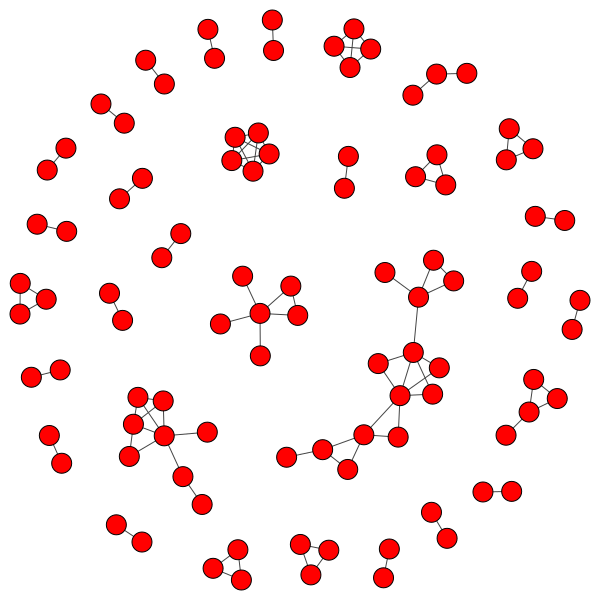

In [143]:
ig.plot(G)

### 4.1 (1a) Make edges thicker between artists with more collaborations

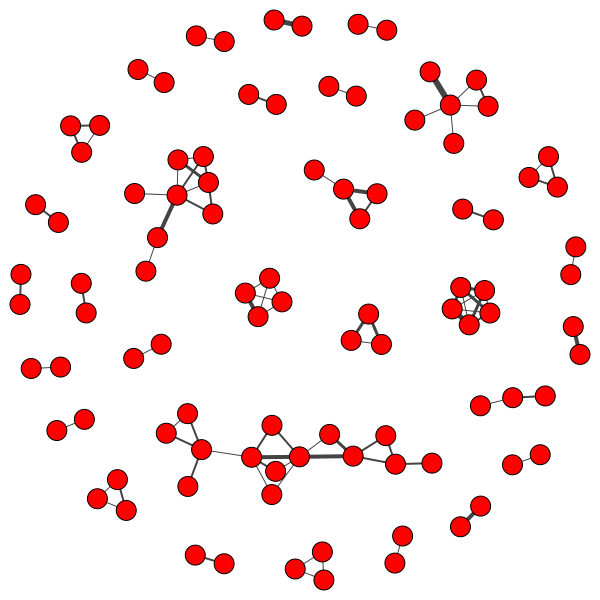

In [157]:
G.es["width"] = G.degree()
ig.plot(G)

### 4.2 Find some large clique(s) of artists, and color them differently, and display only their names

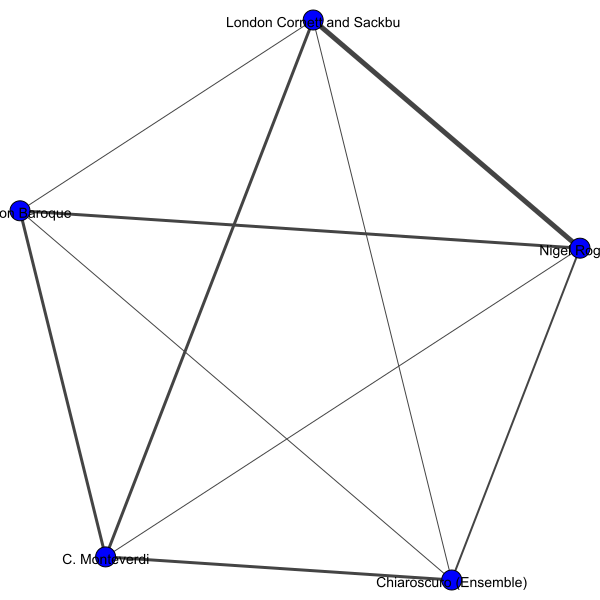

In [160]:
cliques = G.cliques()
largest_clique = max(cliques, key=len) # get only the largest clique

g = G.subgraph(largest_clique)
ig.plot(g, vertex_label=g.vs["Artist"], vertex_color="blue")

### 4.3 Color the graph by [clusters](https://python.igraph.org/en/stable/analysis.html#clustering). What kinds of people or groups do you find?

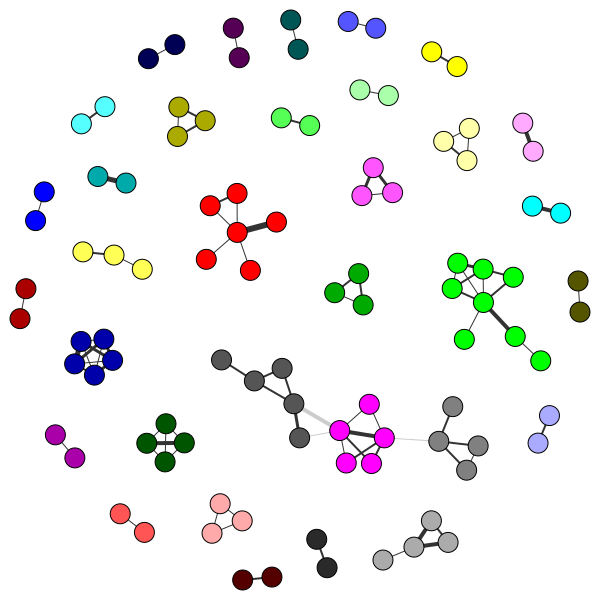

In [198]:
ig.plot(G.community_infomap())

### 4.4 Network Calculations

In [173]:
max(cliques)

(96,)

In [178]:
max(G.degree())

6

In [181]:
min(G.degree()) # so there's apparently an island??? it's not shown though

1

In [184]:
G.diameter()

6

In [187]:
G.average_path_length()

1.9689119170984455

Out of curiousity I wanted to see the subgraph of the largest cluster according to degree.

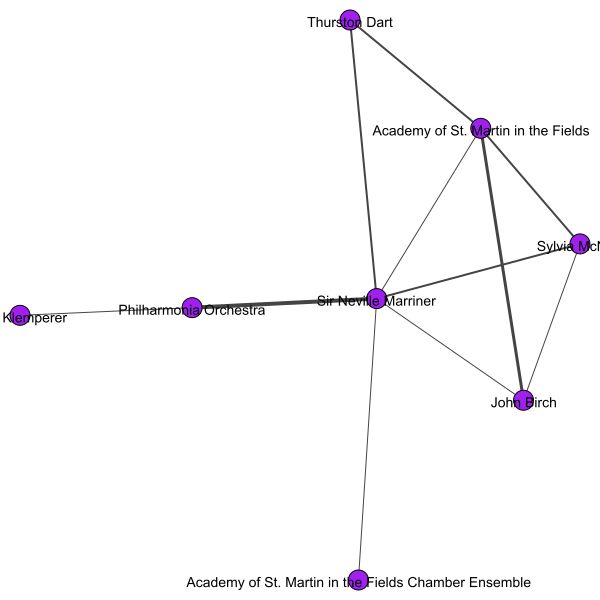

In [192]:
clusters = G.community_infomap()
largest_cluster = max(clusters, key=len) # get only the largest clique

g = G.subgraph(largest_cluster)
ig.plot(g, vertex_label=g.vs["Artist"], vertex_color="purple")

### 4.5 Results and Discussion

1. For the graph in subsection __4.1__, it's good now that we can see the stronger connections between artists according to line thickness, but it seem's somewhat random and don't really follow a pattern.

2. For the graph in subsection __4.2__, I thought I was going to be the longest chain that I could identify from the base graph that would appear as a clique, but it seems to not be that (I guess I don't understand the meaning of cliques?) The inclusion of names thanks to help of the helper table `node` made it easily recognizable that it was one of the weird edge-case entries in which I altered the entry to allow separation.

3. For the graph in subsection __4.3__, I guess it's interesting to see how the longest chain cluster I mentioned isn't all one big color, despite the fact that there exists a mutual between each of the clusters.

## References

<ul style="list-style: none">
    <li>[1] https://www.youtube.com/watch?app=desktop&v=xr7vDSFXjW0</li>
    <li>[2] https://medium.com/@andresberejnoi/how-to-use-sqlalchemy-and-python-to-read-and-write-to-your-database-andres-berejnoi-e99262fd1b34</li>
    <li>[3] https://hackersandslackers.com/database-queries-sqlalchemy-orm/</li>
    <li>[4] https://docs.sqlalchemy.org/en/20/core/engines.html</li>
    <li>[5] https://stackoverflow.com/questions/72823916/how-can-i-make-pandas-read-sql</li>
    <li>[6] https://pandas.pydata.org/docs/reference/api/pandas.merge.html</li>
    <li>[7] https://stackoverflow.com/questions/3640359/regular-expressions-search-in-list</li>
    <li>[8] https://stackoverflow.com/questions/19124601/pretty-print-an-entire-pandas-series-dataframe</li>
    <li>[9] https://www.geeksforgeeks.org/itertools-combinations-module-python-print-possible-combinations/</li>
    <li>[10] https://stackoverflow.com/questions/483666/reverse-invert-a-dictionary-mapping</li>
    <li>[11]https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key</li>
    <li>[12]https://www.w3schools.com/python/numpy/numpy_array_join.asp</li>
    <li>[13]https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html</li>
    <li>[14]https://stackoverflow.com/questions/37855553/python-igraph-community-cluster-colors</li>
    <li>[15]https://python.igraph.org/en/stable/tutorial.html#querying-vertices-and-edges-based-on-attributes</li>
</ul>

## Additional References